In [18]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm 

from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

from models.context_unet import ContextUnet
import ddpm.cu_ddpm as ddpm
from evaluation.evaluation import vizual_comparison, plot_jsd_per_customer, plot_kde_samples, make_gif_from_images, mmd_histogram_per_customer
from evaluation.rmse import rmse


# Params

In [19]:
## Data
seq_len = 12
batch_size = 32
k = 15
customers = 64*64

#NN
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 1000
cond_model = "mlp"
lr = 1e-4
epochs = 2
save_rate = 1

## DDPM
timesteps = 500
beta_schedule = "cosine"
objective = "pred_noise"
betas = [1e-4, 0.02]

#Transformer
latent_dim: 256
num_layers: 4
n_heads: 8

## Logging
experiment = "dev"
experiment_name = f"unet_{epochs//1000}kepochs_{seq_len}seq"
logging_dir = f"logging/{experiment}/{experiment_name}/"

In [20]:
if not os.path.isdir(logging_dir):
    os.makedirs(logging_dir)
    os.makedirs(os.path.join(logging_dir, "viz/"))
    os.makedirs(os.path.join(logging_dir, "jsd/"))
    os.makedirs(os.path.join(logging_dir, "kde/"))
    os.makedirs(os.path.join(logging_dir, "tensorboard/"))
    os.makedirs(os.path.join(logging_dir, "weights/"))
    os.makedirs(os.path.join(logging_dir, "ts_sample/"))
    os.makedirs(os.path.join(logging_dir, "mmd/"))

# Utils

In [21]:
PREPROCESSED_DIR = "./preprocessing/data/customer_led_network_revolution/preprocessed/"

In [22]:
class MakeDATA(Dataset):
    def __init__(self, data, seq_len):
        data = np.asarray(data, dtype=np.float32)
        seq_data = []
        for i in range(len(data) - seq_len + 1):
            x = data[i : i + seq_len]
            seq_data.append(x)
        self.samples = np.asarray(seq_data, dtype=np.float32) 

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

# Load Data

In [23]:
train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "train.csv"))
val = pd.read_csv(os.path.join(PREPROCESSED_DIR, "val.csv"))
test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "test.csv"))
cond_train = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_train.csv"))
cond_val = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_val.csv"))
cond_test = pd.read_csv(os.path.join(PREPROCESSED_DIR, "cond_test.csv"))

In [24]:
train.drop("Date and Time of capture", axis=1, inplace=True)
val.drop("Date and Time of capture", axis=1, inplace=True)
test.drop("Date and Time of capture", axis=1, inplace=True)

In [25]:
col_row = int(np.sqrt(customers))

train = train.iloc[:, :customers]
val = val.iloc[:, :customers]
test = test.iloc[:, :customers]

In [26]:
train_arr = np.asarray(train)
val_arr = np.asarray(val)
test_arr = np.asarray(test)

In [27]:
train_seq = np.asarray(MakeDATA(train_arr, seq_len))
val_seq = np.asarray(MakeDATA(val_arr, seq_len))
test_seq = np.asarray(MakeDATA(test_arr, seq_len))

cond_train_seq = np.asarray(MakeDATA(cond_train, seq_len))
cond_val_seq = np.asarray(MakeDATA(cond_val, seq_len))
cond_test_seq = np.asarray(MakeDATA(cond_test, seq_len))

In [28]:
cond_train_seq.shape

(33973, 12, 27)

In [29]:
img_train = train_seq.reshape(-1, seq_len, col_row, col_row)
img_val = val_seq.reshape(-1, seq_len, col_row, col_row)
img_test = test_seq.reshape(-1, seq_len, col_row, col_row)

img_train.shape, img_val.shape, img_test.shape

((33973, 12, 64, 64), (6785, 12, 64, 64), (1689, 12, 64, 64))

In [30]:
train_dataset = TensorDataset(torch.from_numpy(img_train), torch.from_numpy(cond_train_seq))
train_loader = DataLoader(train_dataset, batch_size, shuffle=False)

val_dataset = TensorDataset(torch.from_numpy(img_val), torch.from_numpy(cond_val_seq))
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)

test_dataset = TensorDataset(torch.from_numpy(img_test), torch.from_numpy(cond_test_seq))
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [31]:
real_data_val, real_cond_data_val = next(iter(val_loader))
real_data_val = real_data_val.reshape(-1, seq_len, 64*64)
real_data_val = real_data_val.permute(0, 2, 1)

real_data_val.shape

torch.Size([32, 4096, 12])

# Load Model

In [32]:
model = ContextUnet(in_channels=seq_len, n_feat=col_row, n_cfeat=cond_train_seq.shape[2], height=col_row, cond_model=cond_model).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)

writer = SummaryWriter(os.path.join(logging_dir, "tensorboard/"))

# Train

In [36]:
import time
from datetime import timedelta

In [37]:
start_time = time.time()

save_dir =  os.path.join(logging_dir, "weights/")
rmse_list = []
lowest_loss = 100000.
lowest_rmse_loss = 100000.
step=0

model.train()
for ep in tqdm(range(epochs)):
    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lr*(1-ep/epochs)
    epoch_loss = 0.0   # initialize epoch loss
    for i, (x, c) in enumerate(train_loader):   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)
        
        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1).unsqueeze(-1)

        # perturb data
        noise = torch.randn_like(x)
        noise = noise.type(torch.float32)
        t = torch.randint(1, timesteps + 1, (x.shape[0],)).to(device)
        x_pert = ddpm.perturb_input(x, t, noise, beta1=betas[0], beta2=betas[1], timesteps=timesteps, device=device)

        # use network to recover noise
        time = t / timesteps
        time = time.type(torch.float32)
        x_pert = x_pert.type(torch.float32)
        c = c.type(torch.float32)
        
        pred_noise = model(x_pert, time, c=c)
        # loss is mean squared error between the predicted and true noise
        loss = F.mse_loss(pred_noise, noise)
        epoch_loss += loss.item()
        loss.backward()
        optim.step()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, ep)
    
    if ep % save_rate == 0:
        ctx = torch.tensor(cond_val_seq[:batch_size]).float().to(device)        
        sample, _ = ddpm.sample_ddpm_context(n_sample=batch_size, context=ctx, channels=seq_len, height=col_row, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
        
        p = sample.repeat(1, 3, 1, 1).cpu()
        q = torch.from_numpy(img_val[:batch_size]).repeat(1, 3, 1, 1) 
        
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)   
        
        sample = sample.reshape(-1, seq_len, 64*64)
        sample = sample.permute(0, 2, 1)
        
        plot_kde_samples(sample, real_data_val,show=False, fpath=os.path.join(logging_dir, "kde/", f"kde_epoch_{ep+1}.png"), epoch=ep+1)
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, ep)
        
        print(f'Epoch: {ep+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse(p,q):.4f}')
        
        if rmse_res < lowest_rmse_loss:
            lowest_rmse_loss = rmse_res
            best_model_params = model.state_dict()
        
        torch.save({
            'epoch': ep+1,
            'diffusion_state_dict': model.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(save_dir, f'ep_{ep}_mse_{avg_epoch_loss:.3f}_rmse_{rmse(p,q):.4f}.pth'))
    
    else:
        print(f'Epoch: {ep+1}, Epoch Loss: {avg_epoch_loss:.4f}')       

import time
from datetime import timedelta

end_time = time.time()
elapsed_time = end_time - start_time
formatted_time = str(timedelta(seconds=int(elapsed_time)))

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1, Epoch Loss: 0.2251, RMSE: 0.4230
Epoch: 2, Epoch Loss: 0.2044, RMSE: 0.2751


In [38]:
out_path = os.path.join(logging_dir, "time/", "compute_time.txt")
os.makedirs(os.path.dirname(out_path), exist_ok=True)
with open(out_path, "w") as f:
    f.write(f"Time to train {epochs} epcohs with batch size {batch_size} and sequece {seq_len}: {formatted_time}")

In [39]:
torch.save(best_model_params,  os.path.join(save_dir, 'best_model.pth'))

In [40]:
model.load_state_dict(torch.load(os.path.join(logging_dir, "weights/", "best_model.pth")))

C:\Users\Arne\AppData\Local\Temp\ipykernel_35288\2280960614.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(logging_dir, "w

<All keys matched successfully>

In [41]:
paths = []
for kde_plot in os.listdir(os.path.join(logging_dir, "kde/")):
    paths.append(os.path.join(logging_dir, "kde/", kde_plot))

make_gif_from_images(paths, os.path.join(logging_dir, "kde/", "kde_progression.gif"))

# Evaluation

In [42]:
ctx = torch.tensor(cond_test_seq[:batch_size]).float().to(device)

In [43]:
with torch.no_grad():
    sample, _ = ddpm.sample_ddpm_context(n_sample=batch_size, context=ctx, channels=seq_len, height=col_row, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
        
    sample = sample.cpu().numpy()
    sample = sample.reshape(-1,12, 64*64)
    sample = sample.transpose(0, 2, 1)

print(f"Samples shape: {sample.shape}")

Samples shape: (32, 4096, 12)


In [44]:
real_test_data = test_seq[:batch_size].transpose(0, 2, 1)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


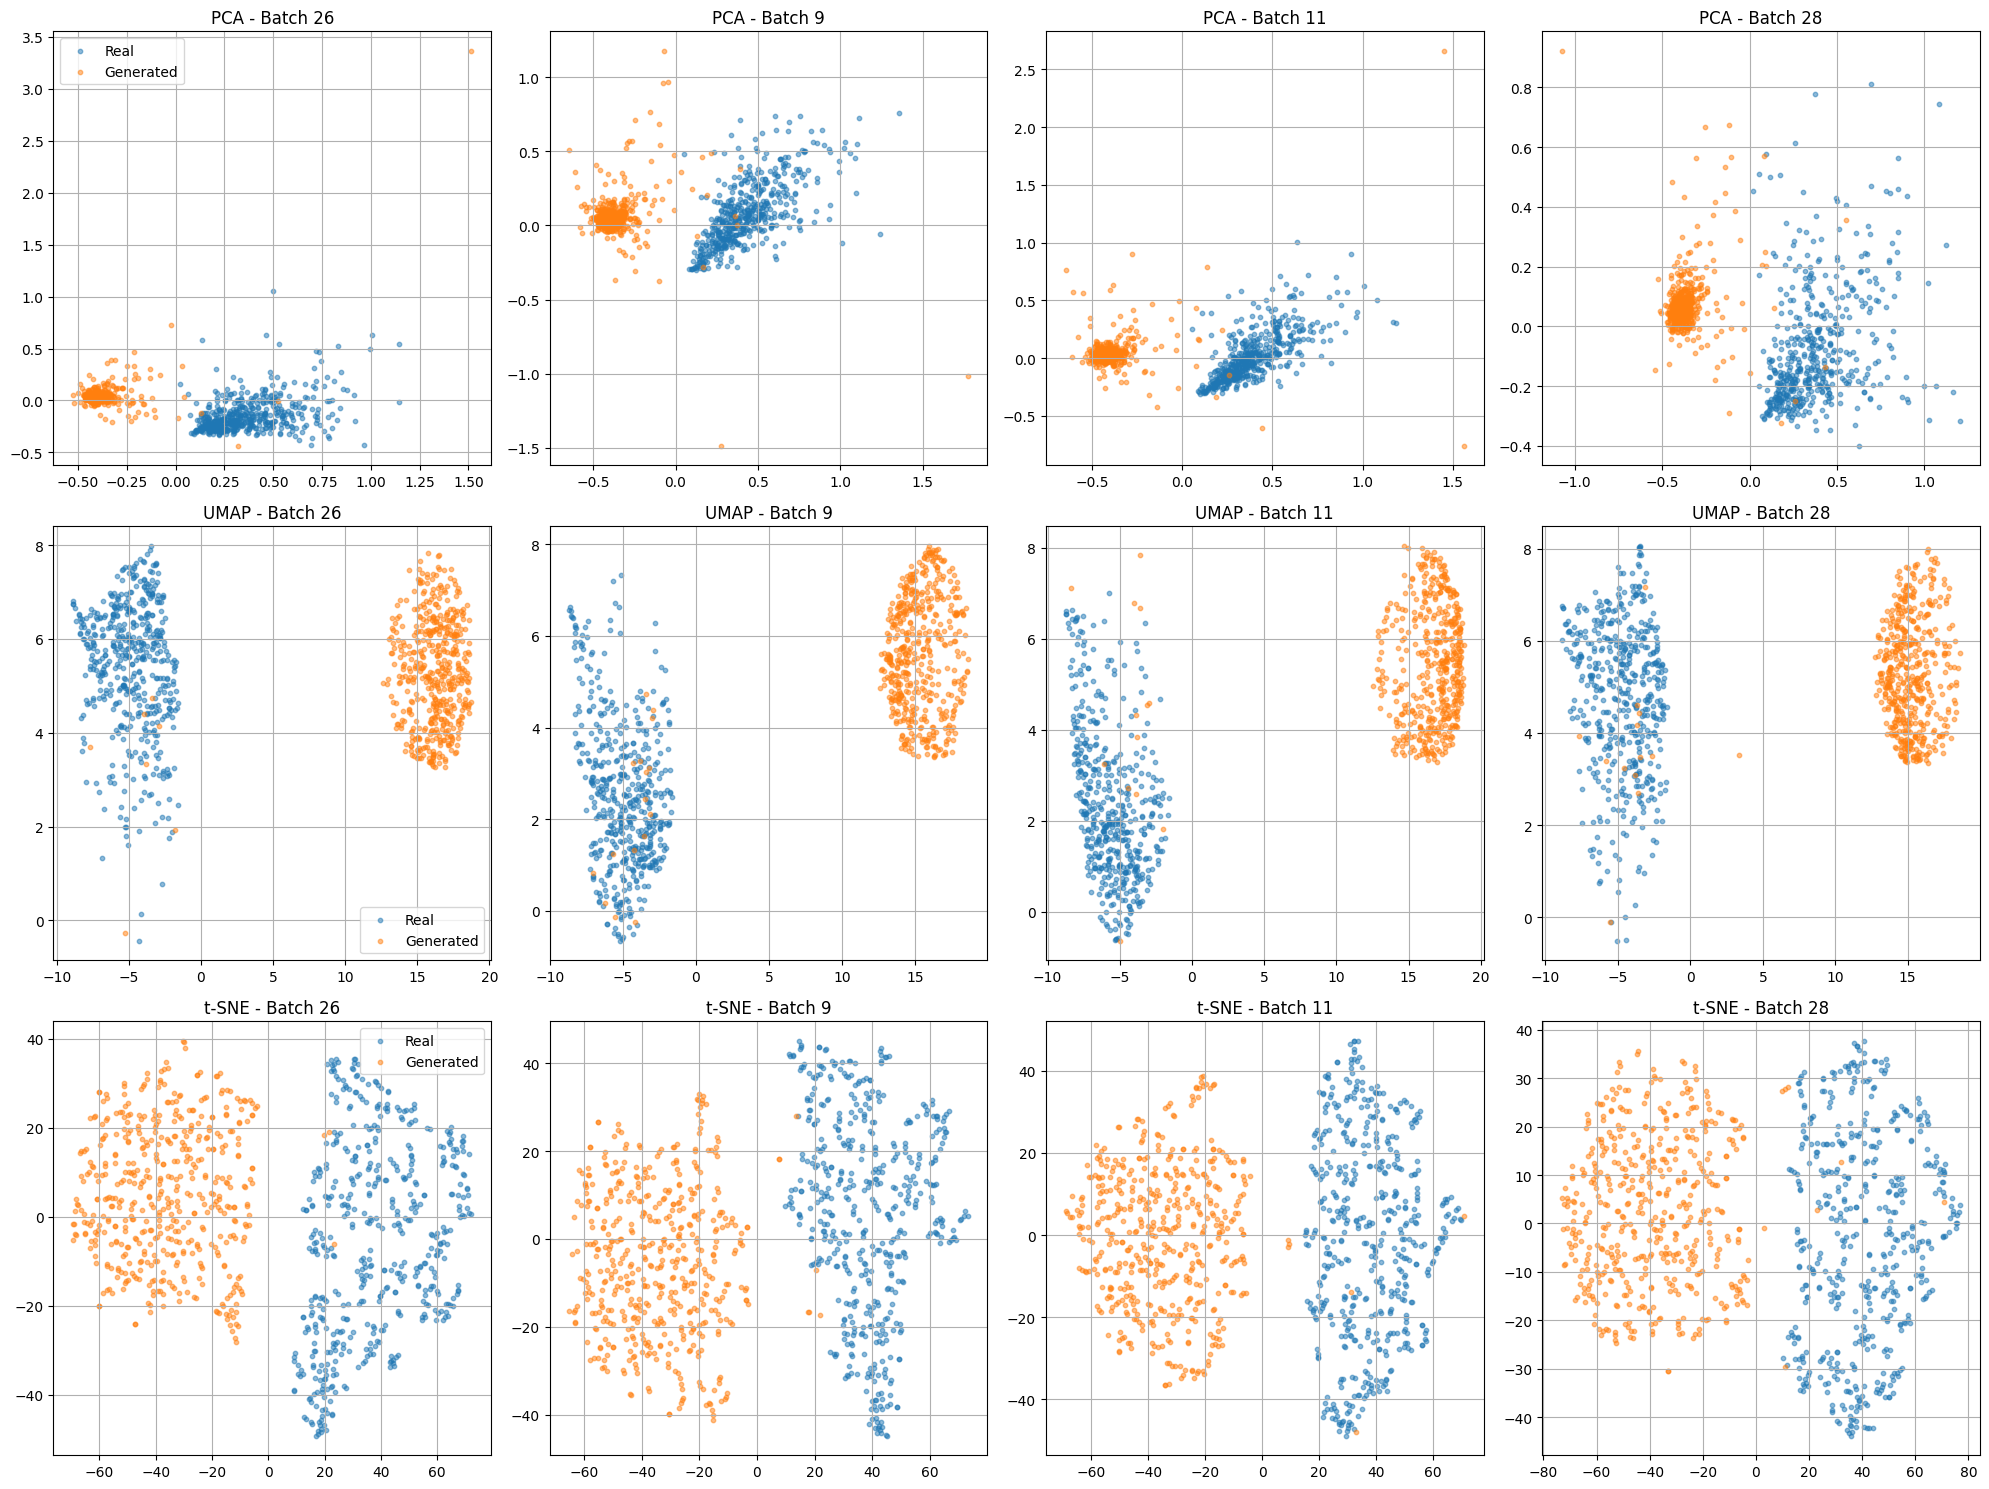

In [45]:
vizual_comparison(sample, real_test_data, os.path.join(logging_dir, "viz/", "pca_umap_tsne.png"), use_all_data=False);

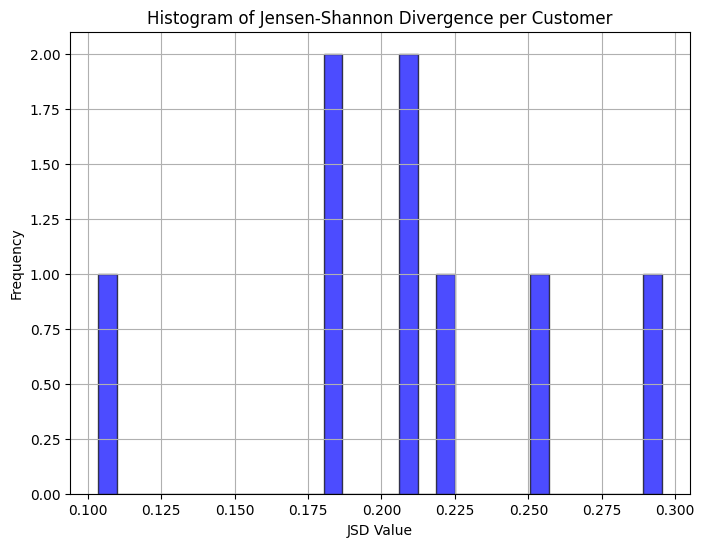

In [46]:
plot_jsd_per_customer(sample, real_test_data, os.path.join(logging_dir, "jsd/", "jsd.png"))

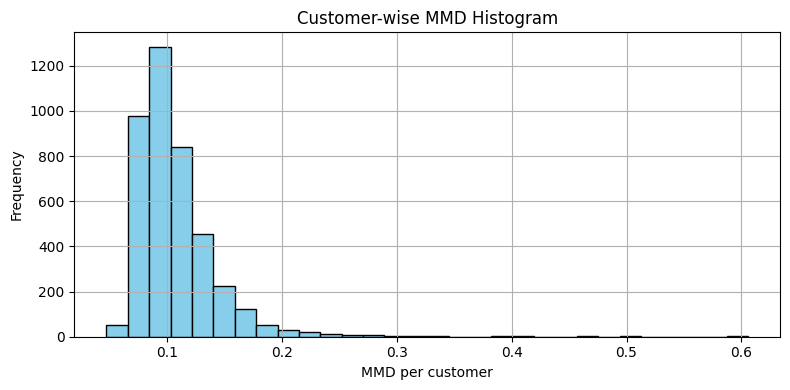

In [47]:
mmd_histogram_per_customer(sample, real_test_data, fpath=os.path.join(logging_dir, "mmd/", "mmd.png"))

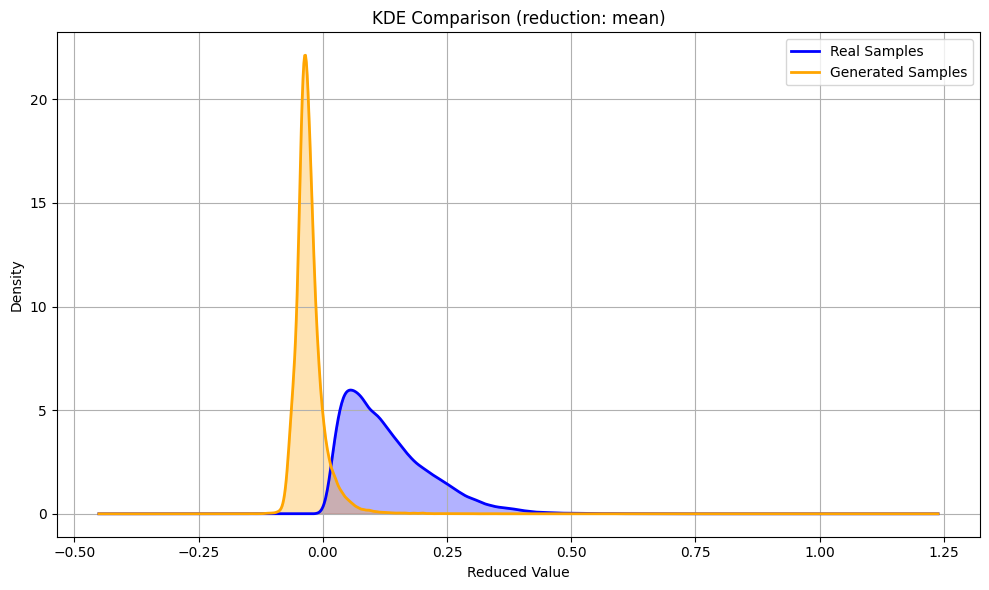

In [48]:
plot_kde_samples(sample, real_test_data, fpath=os.path.join(logging_dir, "kde/", f"kde.png"))

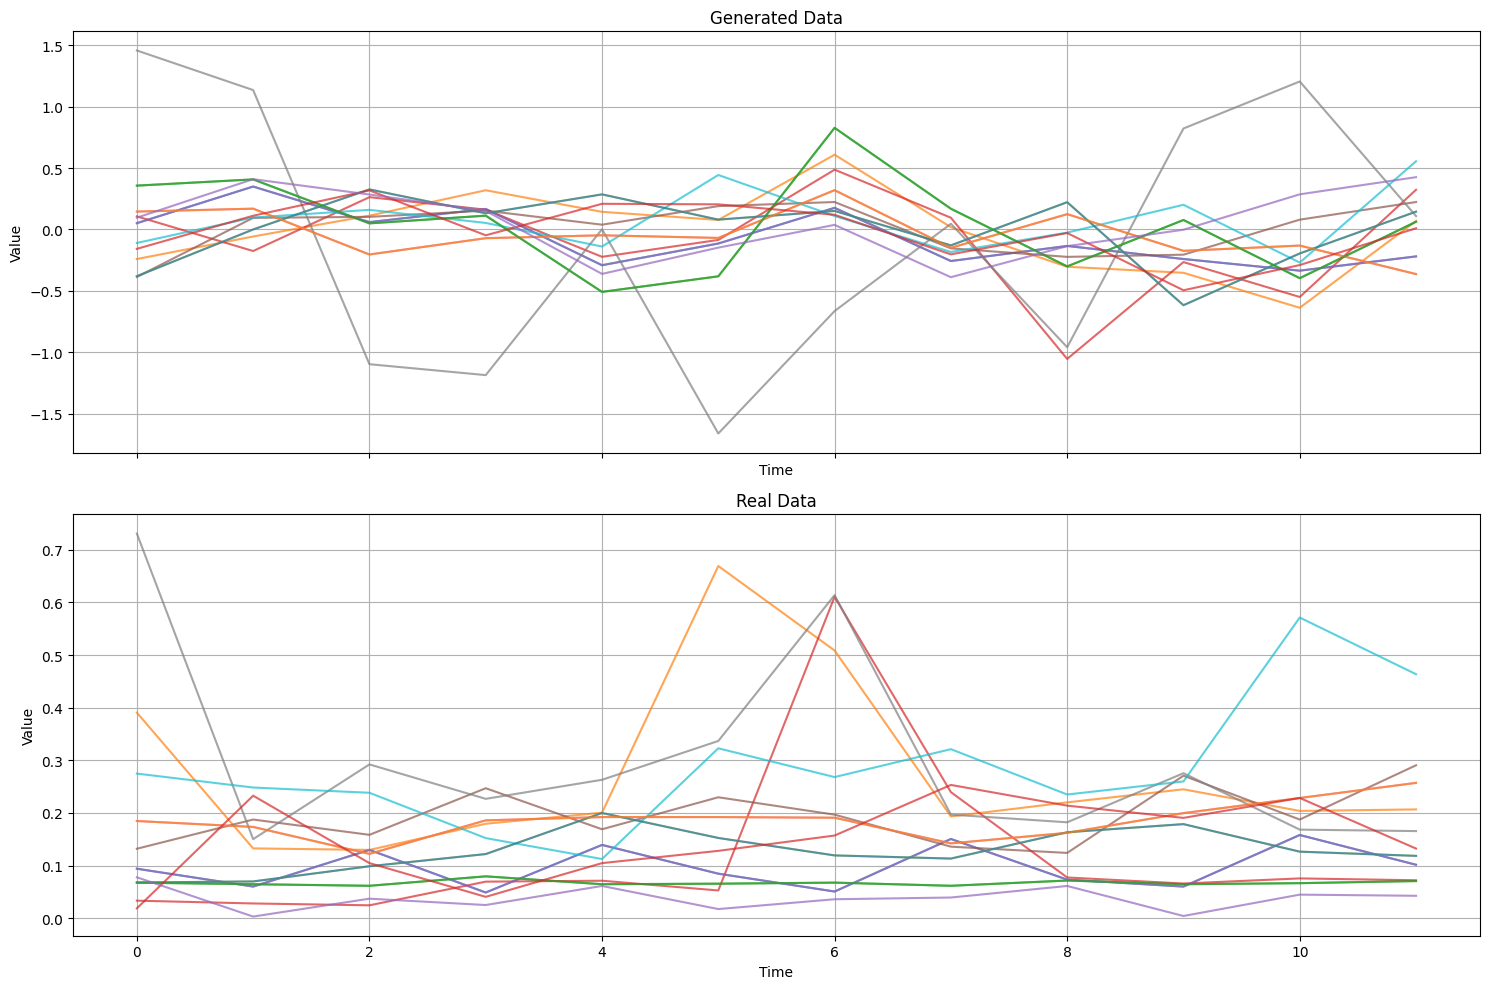

In [49]:
batch_idx = np.random.randint(0, 256) 
customer_indices = np.random.randint(0, 15, size=15)
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

with torch.no_grad():
    sample, _ = ddpm.sample_ddpm_context(n_sample=batch_size, context=ctx, channels=seq_len, height=col_row, 
                                      device=device, timesteps=timesteps, nn_model=model, beta1=betas[0], beta2=betas[1])
        
    sample = sample.cpu().numpy()
    sample = sample.reshape(-1,12, 64*64)
    sample = sample.transpose(0, 2, 1) 

for i in customer_indices:
    axs[0].plot(sample[0, i], alpha=0.7, label=f'Customer {i}')
    axs[1].plot(real_test_data[0, i], alpha=0.7, label=f'Customer {i}')

axs[0].set_title("Generated Data")
axs[1].set_title("Real Data")

for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(logging_dir, "viz/", "samples.png"))
plt.show()